In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import joblib  # For saving the model

Missing X values: 0
Missing Y values: 0


Text(0.5, 0, 'Longitude (X)')

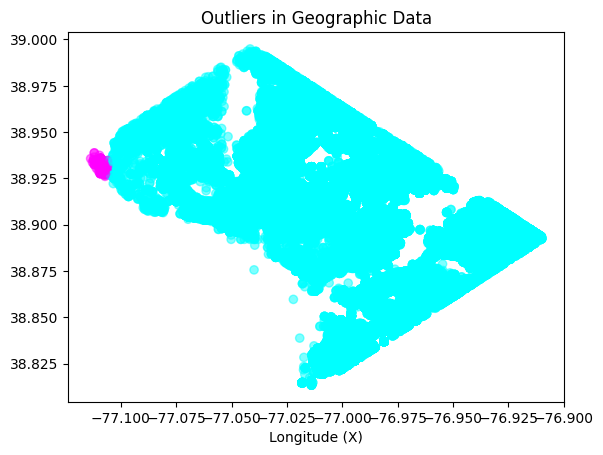

In [2]:
# Phase 1 -- data processing

# missing value and outlier
df = pd.read_csv('major_crime_data.csv')

# Check for missing values in the X and Y columns
missing_x_values = df['X'].isnull().sum()
missing_y_values = df['Y'].isnull().sum()

print(f'Missing X values: {missing_x_values}')
print(f'Missing Y values: {missing_y_values}')

# Define the columns of interest
numerical_columns = ['X', 'Y']

# Calculate Z-scores for numerical columns
z_scores = np.abs((df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std())

# Define the Z-score threshold for identifying outliers
z_score_threshold = 3

# Identify outliers based on Z-scores
outliers_zscore = (z_scores > z_score_threshold).any(axis=1)

# Calculate the IQR for numerical columns
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the IQR threshold for identifying outliers (adjusted from 1-3)
iqr_threshold = 3

# Identify outliers based on IQR
outliers_iqr = ((df[numerical_columns] < (Q1 - iqr_threshold * IQR)) | (df[numerical_columns] > (Q3 + iqr_threshold * IQR))).any(axis=1)

# Combine the results from Z-score and IQR methods
outliers = outliers_zscore | outliers_iqr

# Visualize outliers on a scatter plot
plt.scatter(df['X'], df['Y'], c=outliers, cmap='cool', alpha=0.5)
plt.title('Outliers in Geographic Data')
plt.xlabel('Longitude (X)')

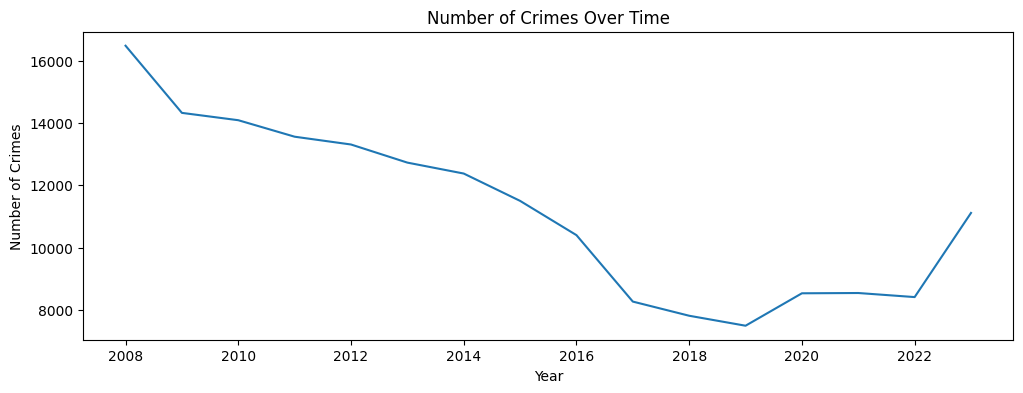

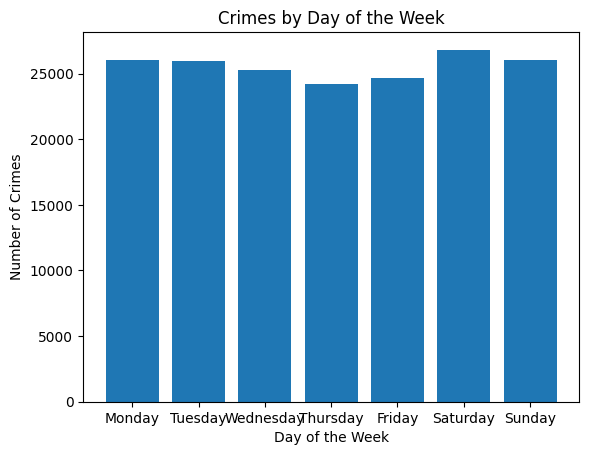

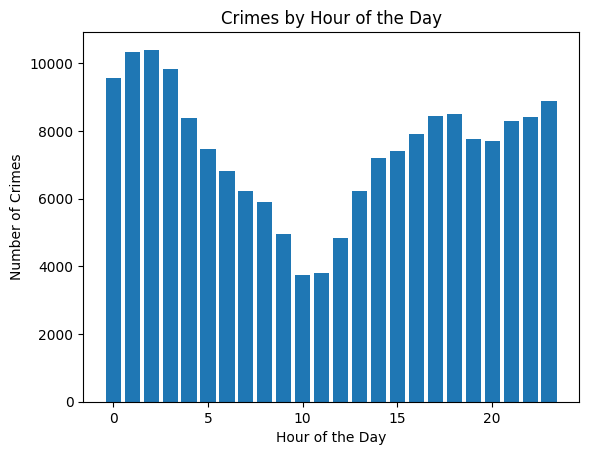

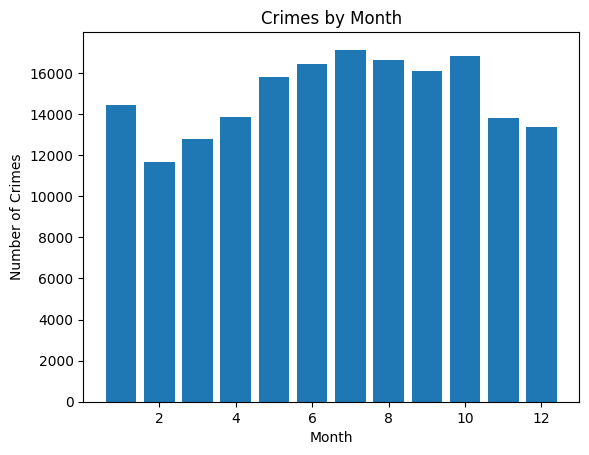

In [3]:
#Phase 2 -- temporal analysis

# Data Preprocessing
crime_data = df
crime_data['REPORT_DAT'] = pd.to_datetime(crime_data['REPORT_DAT'])

# Time-Based Aggregations
crime_data['Year'] = crime_data['REPORT_DAT'].dt.year
crime_data['Month'] = crime_data['REPORT_DAT'].dt.month
crime_data['DayOfWeek'] = crime_data['REPORT_DAT'].dt.dayofweek
crime_data['HourOfDay'] = crime_data['REPORT_DAT'].dt.hour

# Visualizations
# Number of crimes over time
crime_counts_by_year = crime_data['Year'].value_counts().sort_index()
crime_counts_by_month = crime_data['Month'].value_counts().sort_index()
crime_counts_by_day = crime_data['DayOfWeek'].value_counts().sort_index()
crime_counts_by_hour = crime_data['HourOfDay'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
plt.plot(crime_counts_by_year.index, crime_counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Over Time')
plt.show()

# Day of the week analysis
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_counts_by_day.index = days

plt.bar(crime_counts_by_day.index, crime_counts_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.title('Crimes by Day of the Week')
plt.show()

# Time of day analysis
plt.bar(crime_counts_by_hour.index, crime_counts_by_hour.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.title('Crimes by Hour of the Day')
plt.show()

# Seasonal Trends (Monthly)
plt.bar(crime_counts_by_month.index, crime_counts_by_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Crimes by Month')
plt.show()

In [4]:
#Phase 3 -- Computing missing values for neighborhood cluster using random forest classifier

# Split the data into two sets: one with missing 'Cluster' values and one without
df_missing = df[df['NEIGHBORHOOD_CLUSTER'].isnull()].copy()
df_not_missing = df.dropna(subset=['NEIGHBORHOOD_CLUSTER'])

# Features and target variable
X = df_not_missing[['LATITUDE', 'LONGITUDE']]
y = df_not_missing['NEIGHBORHOOD_CLUSTER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict the missing values
predicted_clusters = rf_classifier.predict(df_missing[['LATITUDE', 'LONGITUDE']])

# Assign the predicted values back to the DataFrame
df.loc[df['NEIGHBORHOOD_CLUSTER'].isnull(), 'NEIGHBORHOOD_CLUSTER'] = predicted_clusters[:]

# Evaluate the model (optional)
y_pred_train = rf_classifier.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Training Accuracy: {accuracy_train}')

y_pred_test = rf_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Testing Accuracy: {accuracy_test}')

#save df to csv
#df.to_csv('final_crime_data.csv', index=False)

Training Accuracy: 0.9884583095233056
Testing Accuracy: 0.9853825098061348


In [5]:
#Phase 4 -- Predictive model to predict likelihood of crime and what type of insult has the highest chance.

df2 = df[['REPORT_DAT', 'SHIFT', 'OFFENSE', 'CENSUS_TRACT', 'DISTRICT', 'NEIGHBORHOOD_CLUSTER']]

#transformations-----

#Convert the 'Date' and 'Time' columns to a datetime column
df2['REPORT_DAT'] = pd.to_datetime(df2['REPORT_DAT'])

#Extract the hour from the datetime and add it to a new column
df2['Hour'] = df2['REPORT_DAT'].dt.strftime('%H')

#Extract the date from the datetime and add it to a new column
df2['Date'] = df2['REPORT_DAT'].dt.date

# Drop rows with missing values in either 'Date' or 'Hour' columns
#df2 = df2.dropna(subset=['Date', 'Hour'])

# Ensure 'Hour' is in two-digit format
#df2['Hour'] = df2['Hour'].str.zfill(2)

#Create datetime column based on date and hour
df2['Datetime'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Hour'] + ':00:00')

#subset dataset based on new datetime column
df3 = df2[['Datetime', 'OFFENSE', 'DISTRICT', 'NEIGHBORHOOD_CLUSTER']]

C:\Users\jenn_\AppData\Local\Temp\ipykernel_3924\3264445047.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['REPORT_DAT'] = pd.to_datetime(df2['REPORT_DAT'])
C:\Users\jenn_\AppData\Local\Temp\ipykernel_3924\3264445047.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Hour'] = df2['REPORT_DAT'].dt.strftime('%H')
C:\Users\jenn_\AppData\Local\Temp\ipykernel_3924\3264445047.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [6]:
#you can test with below datapoints
#crime:
#'Tuesday'
#'9'
#'31'

#no crime:
#'Sunday'
#'4'
#'1'

In [7]:
# Define date range for the entire dataset
start_date = df3['Datetime'].min()
end_date = df3['Datetime'].max()

#Generate date-time range for the specified period
hourly_date_range = pd.date_range(start=start_date, end=end_date, freq='H')  # Hourly frequency

# Group data by 'NEIGHBORHOOD_CLUSTER'
grouped = df3.groupby('NEIGHBORHOOD_CLUSTER')

# Create an empty df to store the result
result_df = pd.DataFrame()

# Iterate through each group
for group_name, group_data in grouped:
    # Check for missing dates in the cluster
    missing_dates = hourly_date_range[~hourly_date_range.isin(group_data['Datetime'])]

    # Create rows for the missing dates with appropriate default values
    missing_data = {
        'Datetime': missing_dates,
        'OFFENSE': 'No Offense',
        'NEIGHBORHOOD_CLUSTER': group_name,
    }

    # Create a df for missing data
    missing_df = pd.DataFrame(missing_data)

    # Concatenate missing data with the original dataset
    result_df = pd.concat([df3, missing_df])

# Sort by 'Datetime'
result_df.sort_values(by='Datetime', inplace=True)

# Reset index
result_df.reset_index(drop=True, inplace=True)

# Transform 'OFFENSE' column to the specific offense or 'No Offense'
result_df['OFFENSE'] = result_df['OFFENSE'].apply(lambda x: x if x != 'No Offense' else 'No Offense')

# Transform 'NEIGHBORHOOD_CLUSTER' column to only include the number
result_df['NEIGHBORHOOD_CLUSTER'] = result_df['NEIGHBORHOOD_CLUSTER'].str.extract(r'(\d+)')

# Add a new column for the day of the week
result_df['DayOfWeek'] = result_df['Datetime'].dt.day_name()

# Add a new column for the hour of the day
result_df['HourOfDay'] = result_df['Datetime'].dt.hour

# Subset df based on new columns
result_df = result_df[['OFFENSE', 'NEIGHBORHOOD_CLUSTER', 'DayOfWeek', 'HourOfDay']]

# Mapping dictionary for day names to numeric values
day_mapping = {
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7
}
result_df['DayOfWeek'] = result_df['DayOfWeek'].map(day_mapping)

# Separate data into the majority class (OFFENSE == 'No Offense') and the minority class (OFFENSE != 'No Offense')
majority_class = result_df[result_df['OFFENSE'] == 'No Offense']
minority_class = result_df[result_df['OFFENSE'] != 'No Offense']

# Determine number of samples to undersample from the majority class
undersample_size = len(minority_class)

# Undersample the majority class
undersampled_majority_class = resample(majority_class, replace=True, n_samples=undersample_size, random_state=42)

# Combine undersampled majority class and the minority class
undersampled_df = pd.concat([undersampled_majority_class, minority_class])

# Define target variable and predictor variables
X = undersampled_df[['NEIGHBORHOOD_CLUSTER', 'DayOfWeek', 'HourOfDay']]
y = undersampled_df['OFFENSE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#######################  LOGISTIC REGRESSION ######################

model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)
y_prob = model_LR.predict_proba(X_test)

#######################  Random Forest ######################

model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)
y_prob = model_RF.predict_proba(X_test)

###################### Sample Test Predictions ###################

# Sample Input Data
day_of_week_value = 'Tuesday'
hour_of_day_value = 9
neighborhood_cluster_value = 31
day_of_week_numeric = day_mapping[day_of_week_value]

# Reshape the input features
input_features = np.array([neighborhood_cluster_value, day_of_week_numeric, hour_of_day_value]).reshape(1, -1)

# Make predictions on the input features_LR
predicted_probability_LR = model_LR.predict_proba(input_features)[0, 1]
predicted_offense_LR = model_LR.predict(input_features)[0]

if predicted_offense_LR == 'No Offense':
    print("No likelihood of crime.")
else:
    print(f"Likelihood of crime_LR: {predicted_probability_LR * 100:.2f}%")
    print(f"Predicted offense_LR: {predicted_offense_LR}")

# Make predictions on the input features_RF
predicted_probability_RF = model_RF.predict_proba(input_features)[0, 1]
predicted_offense_RF = model_RF.predict(input_features)[0]

if predicted_offense_RF == 'No Offense':
    print("No likelihood of crime.")
else:
    print(f"Likelihood of crime_RF: {predicted_probability_RF * 100:.2f}%")
    print(f"Predicted offense_RF: {predicted_offense_RF}")

###################### Model Evaluation ###################

# Evaluate Logistic Regression model
print("\nLogistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, model_LR.predict(X_test)))
print("Precision:", precision_score(y_test, model_LR.predict(X_test), average='micro'))
print("Recall:", recall_score(y_test, model_LR.predict(X_test), average='micro'))
print("F1 Score:", f1_score(y_test, model_LR.predict(X_test), average='micro'))

# Evaluate Logistic Regression model using cross-validation
cv_scores_LR = cross_val_score(model_LR, X, y, cv=5)
print("\nLogistic Regression Cross-Validation Scores:")
print("Mean Accuracy:", np.mean(cv_scores_LR))
print("Standard Deviation:", np.std(cv_scores_LR))

# Calculate AUC-ROC for Logistic Regression
y_prob_lr = model_LR.predict_proba(X_test)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
print("AUC-ROC:", roc_auc_lr)

# Evaluate Random Forest model
print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, model_RF.predict(X_test)))
print("Precision:", precision_score(y_test, model_RF.predict(X_test), average='micro'))
print("Recall:", recall_score(y_test, model_RF.predict(X_test), average='micro'))
print("F1 Score:", f1_score(y_test, model_RF.predict(X_test), average='micro'))

# Evaluate Random Forest model using cross-validation
cv_scores_RF = cross_val_score(model_RF, X, y, cv=5)
print("\nRandom Forest Cross-Validation Scores:")
print("Mean Accuracy:", np.mean(cv_scores_RF))
print("Standard Deviation:", np.std(cv_scores_RF))

# Calculate AUC-ROC for Random Forest
y_prob_rf = model_RF.predict_proba(X_test)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
print("AUC-ROC:", roc_auc_rf)


C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Likelihood of crime_LR: 21.48%
Predicted offense_LR: MOTOR VEHICLE THEFT
Likelihood of crime_RF: 28.87%
Predicted offense_RF: ROBBERY

Logistic Regression Metrics:
Accuracy: 0.6096201399851912
Precision: 0.6096201399851912
Recall: 0.6096201399851912
F1 Score: 0.6096201399851912


C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st


Logistic Regression Cross-Validation Scores:
Mean Accuracy: 0.6078230088920342
Standard Deviation: 0.006061292051831363
AUC-ROC: 0.6906696812633497

Random Forest Metrics:
Accuracy: 0.678648765699437
Precision: 0.678648765699437
Recall: 0.678648765699437
F1 Score: 0.678648765699437

Random Forest Cross-Validation Scores:
Mean Accuracy: 0.672585562813321
Standard Deviation: 0.004165301998635279
AUC-ROC: 0.769062886556421


In [12]:
# Phase 5 -- Random Forest model with recommendation system

safety = pd.read_csv('Safety_Recommendations.csv')
def get_recommendations(offense, shift):
    offense_shift_df = safety.loc[(safety['OFFENSE'] == offense) & (safety['SHIFT'] == shift)]
    recommendations = offense_shift_df[['Recommendation 1', 'Recommendation 2', 'Recommendation 3',
                                        'Recommendation 4', 'Recommendation 5', 'Recommendation 6',
                                        'Recommendation 7']].values.flatten()
    return recommendations

model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)
y_prob = model_RF.predict_proba(X_test)

# Sample Input Data
day_of_week_value = 'Tuesday'
hour_of_day_value = 9
neighborhood_cluster_value = 31
day_of_week_numeric = day_mapping[day_of_week_value]

# Reshape the input features
input_features = np.array([neighborhood_cluster_value, day_of_week_numeric, hour_of_day_value]).reshape(1, -1)

# Make predictions on the input features
predicted_probability_RF = model_RF.predict_proba(input_features)[0, 1]
predicted_offense_RF = model_RF.predict(input_features)[0]

if predicted_offense_RF == 'No Offense':
    print("No likelihood of crime.")
else:
    print(f"Likelihood of crime: {predicted_probability_RF * 100:.2f}%")
    print(f"Predicted offense: {predicted_offense_RF}")
    recommendations_RF = get_recommendations(predicted_offense_RF, 'DAY' if hour_of_day_value >= 7 and hour_of_day_value < 19 else 'NIGHT')
    print("Recommendations:")
    for idx, recommendation in enumerate(recommendations_RF, start=1):
        if pd.notna(recommendation):
            print(f"{idx}. {recommendation}")

Likelihood of crime_RF: 28.87%
Predicted offense_RF: ROBBERY
Recommendations_RF:
1. Keep aware of surroundings.
2. Do not carry large amounts of money.
3. Use busy streets during daylight hours.


C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\jenn_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Phase 6 -- preparation for PowerBI export
#######################  Random Forest ######################

model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X, y)
joblib.dump(model_RF, "./final_rf_model.joblib")